<a href="https://colab.research.google.com/github/adrianciemerych/telco_customer_churn_project/blob/main/churn_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
sns.set()

# Organizing the data

In [69]:
# Importing dataset
pd.set_option('display.max_columns', None)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/churn_project/churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [70]:
# Checking info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Dataset has 21 columns and each of them doesn't have null values.

In column TotalCharges we can see object data type when it should be float.

In [71]:
# Checking count of values in individual columns
for col in df.columns:
  print(df[col].value_counts())
  print()

7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

Male      3555
Female    3488
Name: gender, dtype: int64

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

No     3641
Yes    3402
Name: Partner, dtype: int64

No     4933
Yes    2110
Name: Dependents, dtype: int64

1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64

Yes    6361
No      682
Name: PhoneService, dtype: int64

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64

No                   

We can see that the customerID column retains 7043 unique rows so it is unnecessary for us.

It is correct relationship between column PhoneService and MultipleLines - respectively values "No" in first column and "No phone service" in second column have equal count - 682

Same as above, correct relationship is also between column InternetService and columns OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies

In column TotalCharges 11 rows do not have a numeric value. Probably it is reason why dtype of column isn't float

In [72]:
# Removing customerID column
df = df.drop('customerID', axis = 1)

# Printing info about non-numerical values in TotalCharges
print("Values that are not numbers in TotalCharges: \n",
      list(df.sort_values('TotalCharges').head(11)['TotalCharges']))

Values that are not numbers in TotalCharges: 
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']


In [73]:
df.sort_values('TotalCharges').head(20)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
6754,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No


In rows that are inconsistent in term of TotalCharges column, we can see tenure equals to 0. Also the contract is signed for at least on one year and in target column, everywhere churn = 'No', so contract couldn't be broken. These informations may lead to the conclusion that the customers haven't had the opportunity to make a payment yet.

In [74]:
# Replacing string - ' ' to 0
df['TotalCharges'] = df['TotalCharges'].apply(lambda x : 0 if x == ' ' else x)
df['TotalCharges'].value_counts()

0         11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

In [75]:
# Converting column dtypes to int, float or category
for col in df.columns:
  if col in ['tenure']:
    df[col] = df[col].astype(int)
  elif col in ['MonthlyCharges', 'TotalCharges']:
    df[col] = df[col].astype(float)
  else:
    df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   category
 1   SeniorCitizen     7043 non-null   category
 2   Partner           7043 non-null   category
 3   Dependents        7043 non-null   category
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   InternetService   7043 non-null   category
 8   OnlineSecurity    7043 non-null   category
 9   OnlineBackup      7043 non-null   category
 10  DeviceProtection  7043 non-null   category
 11  TechSupport       7043 non-null   category
 12  StreamingTV       7043 non-null   category
 13  StreamingMovies   7043 non-null   category
 14  Contract          7043 non-null   category
 15  PaperlessBilling  7043 non-null   category
 16  PaymentMethod     7043 n

# Visualizing and describing the data

In [76]:
# Showing statistics about numerical data
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


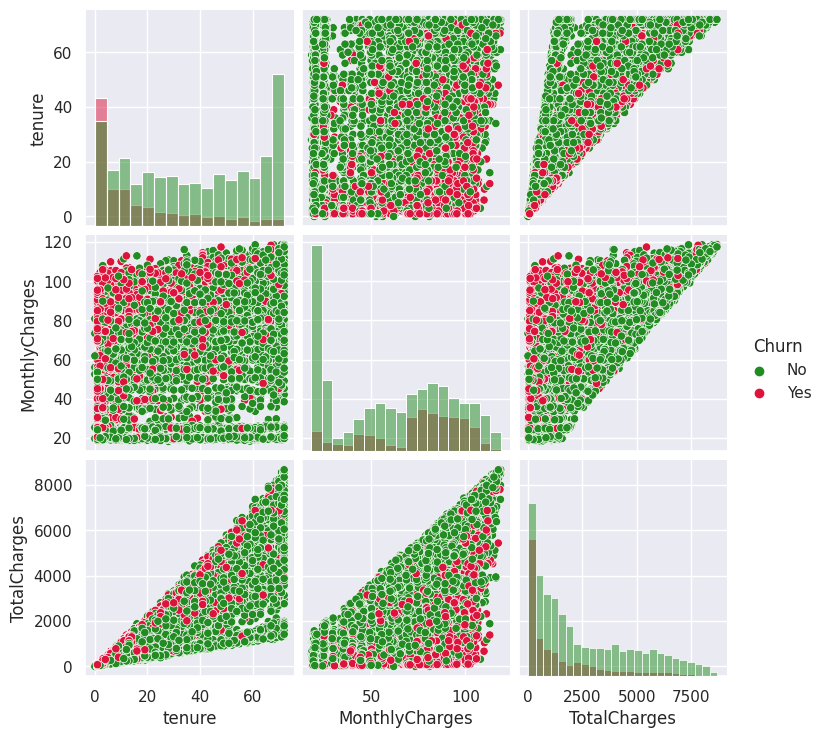

In [77]:
# Making pairplot with numerical data, include split by churn column
sns.pairplot(df, hue = 'Churn', palette = ['#228B22', '#DC143C'], diag_kind = 'hist')

The dataset has 3 numerical variables - tenure, MonthlyCharges and TotalCharges.

1. The first one indicates that the higher number of months a customer has stayed with the company is, the lower chance of this customer resignation.

2. The higher monthly charges, especially from range 75-100 increase risk of customer churn

3. In a chart between tenure and TotalCharges relationship, we can see smooth growth the TotalCharges, when the tenure increases.

4. Scatterplots show, that the dataset doesn't have outliers

In [78]:
# Making a scatterplot with relationship between tenure and
# totalcharges, split by InternetService
px.scatter(df,
           x = 'tenure',
           y = 'TotalCharges',
           color = 'InternetService',
           title = 'Tenure and TotalCharges relationship',
           trendline = 'ols',
           opacity = 0.3)


1. Fiber optic is the most expensive internet service.
2. Total Charges are the smallest when a customer doesn't have Internet Service.
3. Between no internet service and DSL is a quite significant space looking at TotalCharges

In [79]:
# Showing category variables statistics
df.describe(include = 'category')

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


<ipython-input-80-befa0283a3de>:13: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-80-befa0283a3de>:13: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-80-befa0283a3de>:13: UserWarning:

FixedFormatter should only be used together with FixedLocator



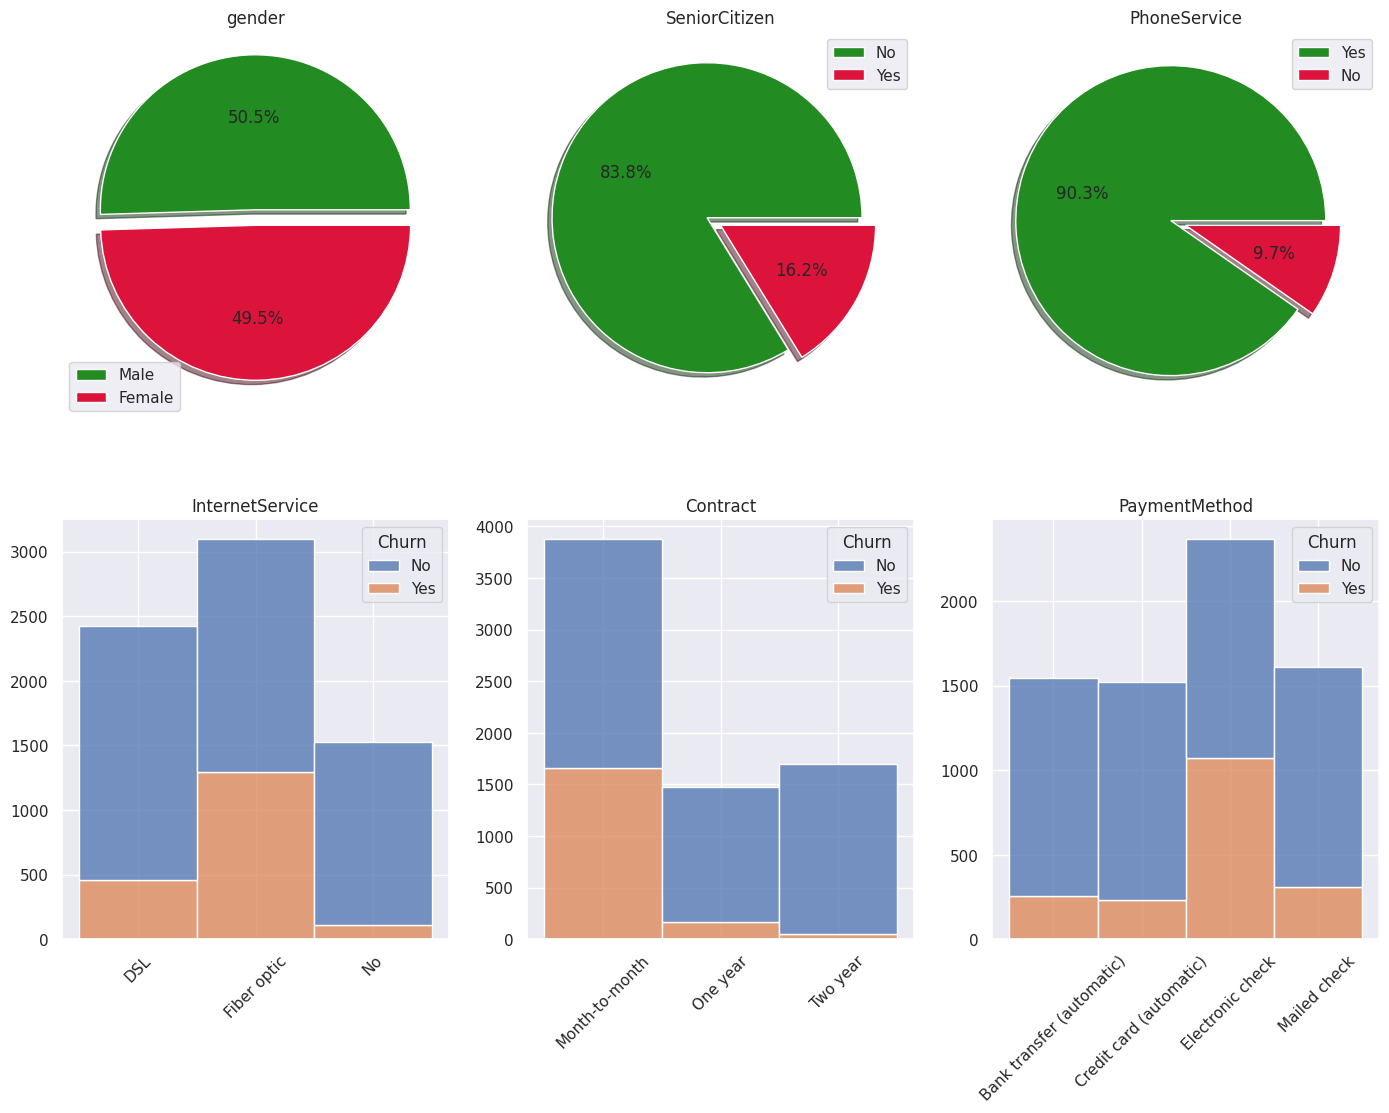

In [80]:
# Making plots for 6 interesting variables
fig, ax = plt.subplots(2,3, figsize = (17,12))
for index, col in enumerate(['gender', 'SeniorCitizen', 'PhoneService']):
  df[col].value_counts().plot(kind = 'pie', ax = ax[0,index], shadow = True,
                              title = col, colors = ['#228B22', '#DC143C'],
                              explode = [0.1, 0], autopct = '%1.1f%%',
                              labels = ['', ''], ylabel = '')
for index, col in enumerate(['InternetService', 'Contract', 'PaymentMethod']):
  sns.histplot(data = df, x = col, ax = ax[1, index], hue = 'Churn', multiple = 'stack')
  ax[1, index].title.set_text(col)
  ax[1, index].set_xlabel('')
  ax[1, index].set_ylabel('')
  ax[1, index].set_xticklabels(ax[1,index].get_xticklabels(), rotation = 45)

ax[0, 0].legend(['Male', 'Female'])
ax[0, 1].legend(['No', 'Yes'])
ax[0, 2].legend(['Yes', 'No'])
fig.show()

Above charts representing categorical variables distributions.

1. On the first graph is displayed a gender distribution. It is spread almost  equally with slightly prevalence for males.
2. There is 16% senior citizens in the dataset
3. 90 % of all customers in the dataset have purchased a phone service
4. The most popular internet service is Fiber optic. Number of customers who stayed with the company is aproximately between services. Unfortunately  the fiber optic, despite the most popularity has also a very high number of customers, who left the company
5. The most often customer's choice is contract month-to-month. In one year and two year contracts is very low number of churn
6. Electronic check is an outstanding factor in a payment method. Customers who pay, using this method make up the largest count in the dataset but nearly half of them resigned from the company

In [81]:
# Describing data when churn = 'Yes'
stats_churn_yes = df[df['Churn'] == 'Yes'].describe().T

# Describing data when churn = 'No'
stats_churn_no = df[df['Churn'] == 'No'].describe().T

# Creating dataframe with means include split by churn
mean_comparison_by_churn = pd.DataFrame({'mean_yes' : stats_churn_yes['mean'],
                                         'mean_no' : stats_churn_no['mean']})
mean_comparison_by_churn = mean_comparison_by_churn.T.reset_index(drop = True)
mean_comparison_by_churn['Churn'] = ['Yes', 'No']
mean_comparison_by_churn = round(mean_comparison_by_churn)
mean_comparison_by_churn

,tenure,MonthlyCharges,TotalCharges,Churn
0,18.0,74.0,1532.0,Yes
1,38.0,61.0,2550.0,No


In [82]:
# From above data, creating bar plots
fig = make_subplots(cols = 3,
                    subplot_titles = ('Average tenure',
                                      'Average monthly charges',
                                      'Average total charges'),
                    column_titles = ['Churn', 'Churn', 'Churn'])
fig.add_bar(x = mean_comparison_by_churn['Churn'],
            y = mean_comparison_by_churn['tenure'],
            row = 1,
            col = 1,
            name = 'tenure')
fig.add_bar(x = mean_comparison_by_churn['Churn'],
            y = mean_comparison_by_churn['MonthlyCharges'],
            row = 1,
            col = 2,
            name = 'MonthlyCharges')
fig.add_bar(x = mean_comparison_by_churn['Churn'],
            y = mean_comparison_by_churn['TotalCharges'],
            row = 1,
            col = 3,
            name = 'TotalCharges')
fig.layout.annotations[3].y = -0.15
fig.layout.annotations[4].y = -0.15
fig.layout.annotations[5].y = -0.15
fig.update_layout(title_text = 'Comparison of numerical columns averages in terms of churn',
                  title = {'x' : 0.5})
fig.show()

Charts depict comparison between means of numerical variables with data split by churn. Looking on these charts we can say:
1. Difference between customers who stayed with the company and those who resigned is tremendous (38 to 18 months).
2. Average monthly charges are higher for customers who left the company
3. Average total charges are higher for customers who stayed with company

In [83]:
# Showing statistics for category variables filtered by churn = 'Yes'
df[df['Churn'] == 'Yes'].describe(include = 'category')

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,1
top,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes
freq,939,1393,1200,1543,1699,850,1297,1461,1233,1211,1446,942,938,1655,1400,1071,1869


In above statistics we can see that the 1200 of 1869 customers who resigned from the company, don't have a partner.

Similarly, data referring to the dependents column. Here is a very huge prevalence for customers who don't have dependets (1543 of 1869 customers).

It will be good idea to make plot with breakdown by these factors

In [84]:
# Histograms with count of churn, regarding if customers have partner and dependents
fig = px.histogram(df,
                   x = 'Churn',
                   facet_row = 'Partner',
                   facet_col = 'Dependents',
                   color = 'Churn',
                   text_auto = True)
fig.update_layout(font = {'size' : 16})

1. Looking on graphs it is clear to see that the most of customers don't have partner and dependents. In this case about 33% have resigned from the company.
2. The number of customers who don't have partner but have dependents is very interesting. It is equal only about 361 customers, when in the whole dataset are 7043 of them.
3. There is a slighty difference between number of customers who have a partner but don't have dependents (1653), compared to number of those who have a partner and dependents (1749). The higher difference will appear, when we consider additionally a split by churn. In the first case the churn = 'Yes' takes about 25% of these customers, whereas in the second group churn = 'Yes' takes only 14%

In [85]:
# Making a table which calculates an average of numerical variables grouped by
# partner and dependents
agg_df = df[['tenure', 'MonthlyCharges', 'TotalCharges',
             'Partner', 'Dependents']].groupby(['Partner', 'Dependents']).agg('mean')
round(agg_df)

tenure  MonthlyCharges  TotalCharges
Partner Dependents                                      
No      No            23.0            63.0        1611.0
        Yes           24.0            53.0        1342.0
Yes     No            43.0            75.0        3333.0
        Yes           41.0            61.0        2733.0

It is a table with averages of numerical variables grouped by partner and dependents.

In this table can we see that the customers who have a partner are marked by longer time in the company. Also their monthly charges and total charges are higher than those with no partner.

Average monthly and total charges in relation to dependents are higher, where customers don't have dependents.






# Converting categorical data, splitting dataset, standarizing numerical data

In [86]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [87]:
from sklearn.preprocessing import LabelEncoder

# Getting dummies
df_dummies = pd.get_dummies(df,
                            columns = [col
                                       for col in df.columns
                                       if col not in ['tenure',	'MonthlyCharges',
                                                      'TotalCharges', 'Churn']],
                            drop_first = True)

# Converting target values to binary
le = LabelEncoder()
df_dummies['Churn'] = le.fit_transform(df_dummies['Churn'])

df_dummies.head(3)

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,34,56.95,1889.50,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,2,53.85,108.15,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [88]:
# Splitting data to data and target
data = df_dummies.copy()
target = data.pop('Churn')
data.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,34,56.95,1889.50,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,45,42.30,1840.75,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
4,2,70.70,151.65,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [89]:
target.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [90]:
# Splitting the data and target on train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, stratify = target)


print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)
print(f'\nDistribution of y_train:\n{y_train.value_counts()}\n')
print(f'Distribution of y_test:\n{y_test.value_counts()}')

Shape of X_train: (5634, 30)
Shape of y_train: (5634,)
Shape of X_test: (1409, 30)
Shape of y_test: (1409,)

Distribution of y_train:
0    4139
1    1495
Name: Churn, dtype: int64

Distribution of y_test:
0    1035
1     374
Name: Churn, dtype: int64


In [91]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 768 to 854
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 5634 non-null   int64  
 1   MonthlyCharges                         5634 non-null   float64
 2   TotalCharges                           5634 non-null   float64
 3   gender_Male                            5634 non-null   uint8  
 4   SeniorCitizen_1                        5634 non-null   uint8  
 5   Partner_Yes                            5634 non-null   uint8  
 6   Dependents_Yes                         5634 non-null   uint8  
 7   PhoneService_Yes                       5634 non-null   uint8  
 8   MultipleLines_No phone service         5634 non-null   uint8  
 9   MultipleLines_Yes                      5634 non-null   uint8  
 10  InternetService_Fiber optic            5634 non-null   uint8  
 11  Int

In [92]:
# Standarizing numerical data to mean = 0 and variance = 1
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(X_train[['tenure', 'MonthlyCharges', 'TotalCharges']])

X_test[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.transform(X_test[['tenure', 'MonthlyCharges', 'TotalCharges']])


X_train_means = [round(X_train[col].mean(), 3) for col in ['tenure', 'MonthlyCharges', 'TotalCharges']]
X_test_means = [round(X_test[col].mean(), 3) for col in ['tenure', 'MonthlyCharges', 'TotalCharges']]
X_train_variance = [round((X_train[col].std())**2, 3) for col in ['tenure', 'MonthlyCharges', 'TotalCharges']]
X_test_variance = [round((X_test[col].std())**2, 3) for col in ['tenure', 'MonthlyCharges', 'TotalCharges']]

print('Means for X_train numerical columns:', X_train_means)
print('Means for X_test numerical columns:', X_test_means)
print('Variances for X_train numerical columns:', X_train_variance)
print('Variances for X_test numerical columns:', X_test_variance)

Means for X_train numerical columns: [0.0, 0.0, -0.0]
Means for X_test numerical columns: [-0.006, 0.009, 0.0]
Variances for X_train numerical columns: [1.0, 1.0, 1.0]
Variances for X_test numerical columns: [0.989, 1.008, 0.989]


# Selecting features

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

# Selecting features based on the Random forest classifier's property "feature_importances_"

classifier = RandomForestClassifier(1000)
classifier.fit(X_train, y_train)

importances = classifier.feature_importances_
df_rf_importance = pd.DataFrame({'feat' : list(X_train.columns),
                                 'importance' : list(importances)})

df_rf_importance = df_rf_importance.sort_values('importance', ascending = False)
df_rf_importance = df_rf_importance.reset_index(drop = True)
df_rf_importance

,feat,importance
0,TotalCharges,0.196817
1,tenure,0.170437
2,MonthlyCharges,0.168608
3,InternetService_Fiber optic,0.039396
4,PaymentMethod_Electronic check,0.034524
5,Contract_Two year,0.030930
6,gender_Male,0.028639
7,OnlineSecurity_Yes,0.026921
8,PaperlessBilling_Yes,0.025600
9,TechSupport_Yes,0.025226


As we can see on above table, columns with "No internet service" and "phone service" often are less significant than other columns.

The most significant columns in the dataset for this type of feature selection are numerical columns (TotalCharges, tenure, MonthlyCharges).

Below we will make simulation how numer of features influence on working models (for example Random forest classifier and Logistic Regression)

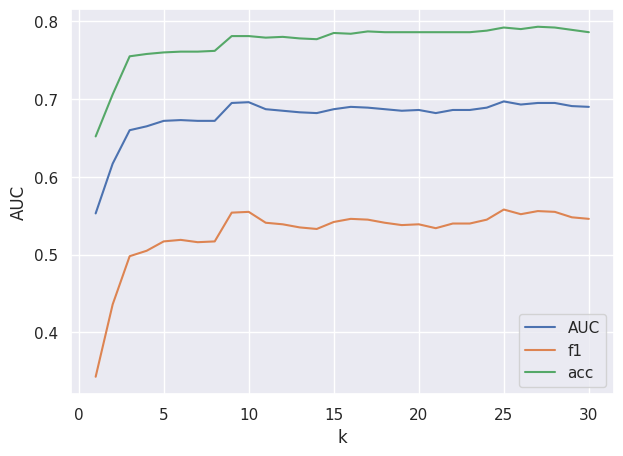

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
k,1.000,2.000,3.000,4.000,5.000,6.000,7.000,8.000,9.000,10.000,11.000,12.000,13.000,14.000,15.000,16.000,17.000,18.000,19.000,20.000,21.000,22.000,23.000,24.000,25.000,26.000,27.000,28.000,29.000,30.000
AUC,0.553,0.617,0.660,0.665,0.672,0.673,0.672,0.672,0.695,0.696,0.687,0.685,0.683,0.682,0.687,0.690,0.689,0.687,0.685,0.686,0.682,0.686,0.686,0.689,0.697,0.693,0.695,0.695,0.691,0.690
f1,0.343,0.436,0.498,0.505,0.517,0.519,0.516,0.517,0.554,0.555,0.541,0.539,0.535,0.533,0.542,0.546,0.545,0.541,0.538,0.539,0.534,0.540,0.540,0.545,0.558,0.552,0.556,0.555,0.548,0.546
acc,0.652,0.706,0.755,0.758,0.760,0.761,0.761,0.762,0.781,0.781,0.779,0.780,0.778,0.777,0.785,0.784,0.787,0.786,0.786,0.786,0.786,0.786,0.786,0.788,0.792,0.790,0.793,0.792,0.789,0.786
precision,0.344,0.444,0.546,0.552,0.555,0.557,0.557,0.561,0.602,0.604,0.601,0.607,0.602,0.601,0.624,0.618,0.629,0.627,0.629,0.631,0.631,0.628,0.628,0.633,0.640,0.636,0.648,0.642,0.636,0.626
recall,0.342,0.428,0.457,0.465,0.484,0.487,0.481,0.479,0.513,0.513,0.492,0.484,0.481,0.479,0.479,0.489,0.481,0.476,0.471,0.471,0.463,0.473,0.473,0.479,0.495,0.487,0.487,0.489,0.481,0.484


In [94]:
# Plotting relationship between number of features and metrics: f1 score, AUC, accuracy
# Creating a dataframe with number of features and corresponding to each values of
# metrics (AUC, f1 score, accuracy, precision, recall)
def feats_selection_comparison(X_train, X_test, y_train, y_test, ordered_columns, classifier = RandomForestClassifier()):
  df = pd.DataFrame(columns = ['k', 'AUC', 'f1', 'acc', 'precision', 'recall'])
  for k in range(1, len(ordered_columns) + 1):
    X_train_k = X_train[ordered_columns[:k]]
    X_test_k = X_test[ordered_columns[:k]]

    classifier = classifier
    classifier.fit(X_train_k, y_train)

    y_pred = classifier.predict(X_test_k)

    acc = round(accuracy_score(y_test, y_pred), 3)
    auc = round(roc_auc_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, zero_division=0), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    df.loc[len(df)] = [k, auc, f1, acc, precision, recall]

  plt.figure(figsize = (7,5))
  sns.lineplot(df, x = 'k', y = 'AUC', label = 'AUC')
  sns.lineplot(df, x = 'k', y = 'f1', label = 'f1')
  sns.lineplot(df, x = 'k', y = 'acc', label = 'acc')
  plt.show()

  return df.T

feats_selection_comparison(X_train, X_test, y_train, y_test,
                           list(df_rf_importance['feat']),
                           classifier = RandomForestClassifier(1000))

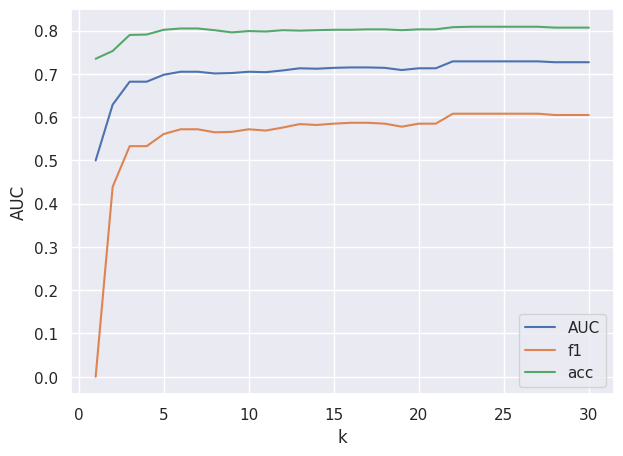

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
k,1.000,2.000,3.000,4.000,5.000,6.000,7.000,8.000,9.000,10.000,11.000,12.000,13.000,14.000,15.000,16.000,17.000,18.000,19.000,20.000,21.000,22.000,23.000,24.000,25.000,26.000,27.000,28.000,29.000,30.000
AUC,0.500,0.629,0.682,0.682,0.698,0.705,0.705,0.701,0.702,0.705,0.704,0.708,0.713,0.712,0.714,0.715,0.715,0.714,0.709,0.713,0.713,0.729,0.729,0.729,0.729,0.729,0.729,0.727,0.727,0.727
f1,0.000,0.439,0.533,0.533,0.561,0.572,0.572,0.565,0.566,0.572,0.569,0.576,0.584,0.582,0.585,0.587,0.587,0.585,0.578,0.585,0.585,0.608,0.608,0.608,0.608,0.608,0.608,0.605,0.605,0.605
acc,0.735,0.753,0.790,0.791,0.802,0.805,0.805,0.801,0.796,0.799,0.798,0.801,0.800,0.801,0.802,0.802,0.803,0.803,0.801,0.803,0.803,0.808,0.809,0.809,0.809,0.809,0.809,0.807,0.807,0.807
precision,0.000,0.553,0.650,0.656,0.682,0.684,0.684,0.674,0.652,0.659,0.655,0.661,0.651,0.656,0.659,0.658,0.663,0.662,0.662,0.666,0.666,0.666,0.668,0.668,0.668,0.668,0.668,0.662,0.662,0.662
recall,0.000,0.364,0.452,0.449,0.476,0.492,0.492,0.487,0.500,0.505,0.503,0.511,0.529,0.524,0.527,0.529,0.527,0.524,0.513,0.521,0.521,0.559,0.559,0.559,0.559,0.559,0.559,0.556,0.556,0.556


In [95]:
feats_selection_comparison(X_train, X_test, y_train, y_test,
                           list(df_rf_importance['feat']),
                           classifier = LogisticRegression())


Looking at created plots and tables we can see that the best results we will receive, when we select first 25 features. In the next step we will drop unnecesary columns.

In [96]:
X_train = X_train[list(df_rf_importance['feat'])[:25]]
X_test = X_test[list(df_rf_importance['feat'])[:25]]
X_train.head(3)

,TotalCharges,tenure,MonthlyCharges,InternetService_Fiber optic,PaymentMethod_Electronic check,Contract_Two year,gender_Male,OnlineSecurity_Yes,PaperlessBilling_Yes,TechSupport_Yes,Partner_Yes,OnlineBackup_Yes,Contract_One year,SeniorCitizen_1,MultipleLines_Yes,Dependents_Yes,DeviceProtection_Yes,StreamingMovies_Yes,StreamingTV_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Mailed check,StreamingTV_No internet service,DeviceProtection_No internet service,InternetService_No,OnlineSecurity_No internet service
768,0.356763,0.349686,0.317382,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5847,1.532538,1.203790,0.974296,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0
5400,0.055780,0.024313,0.189325,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<Axes: >

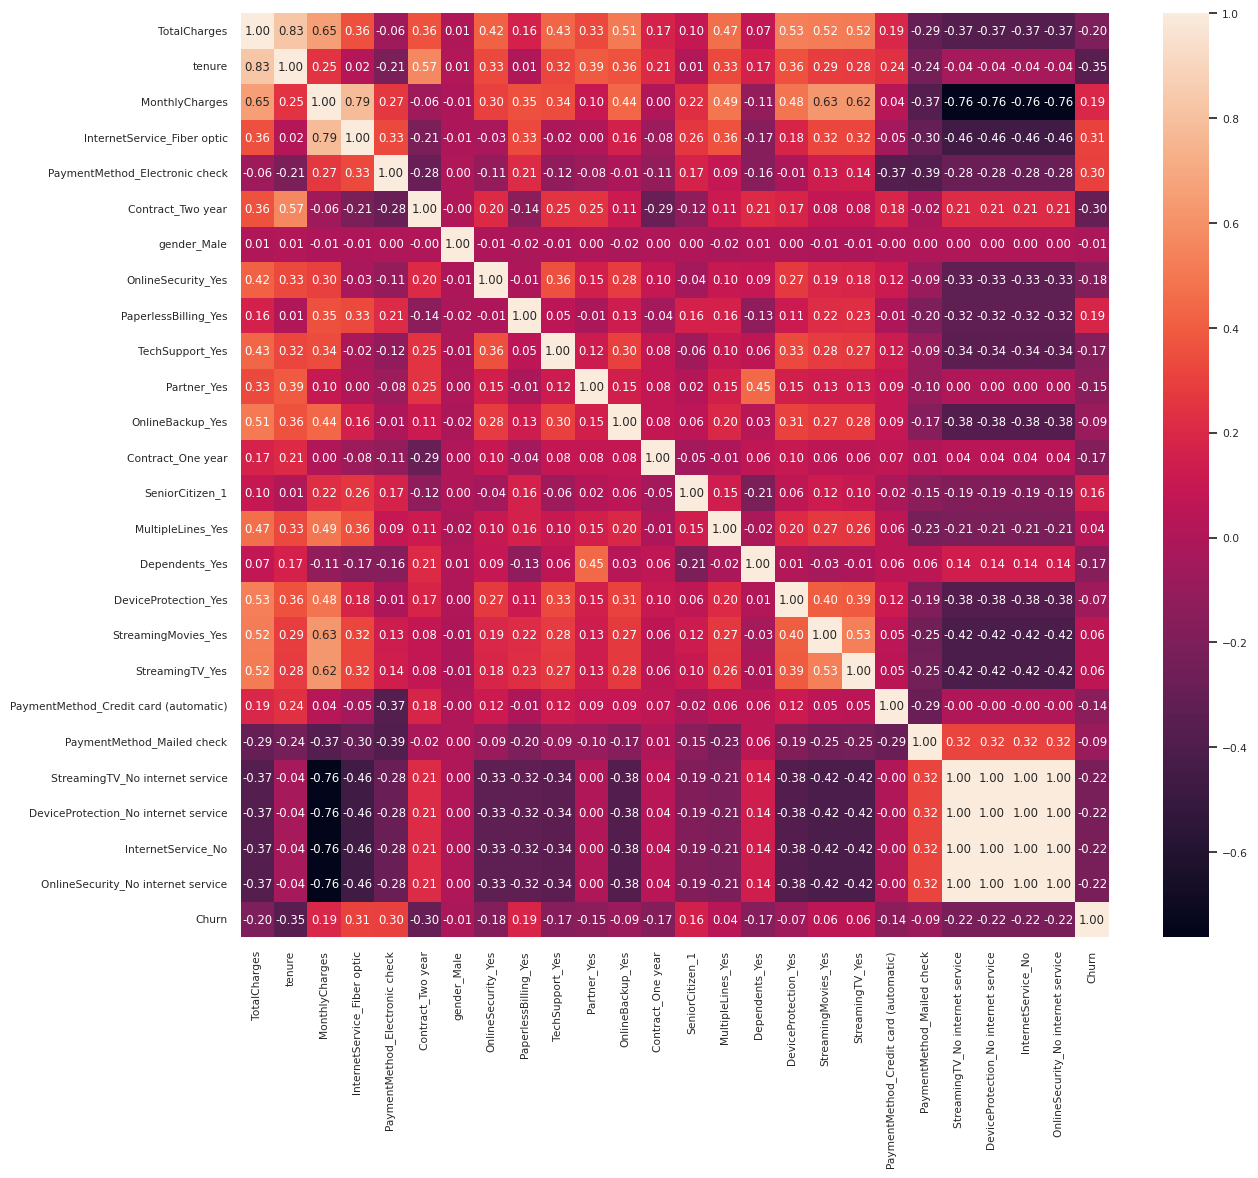

In [97]:
# Creating correlation matrix
corr_matrix = pd.concat([X_train.reset_index(drop = True),
                         y_train.reset_index(drop = True)], axis = 1).corr()
sns.set_theme(font_scale = 0.7)
plt.figure(figsize = (14,12))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f')

On heat map it's clear to see, that the last 4 variables are in 100% correlated each with each. From these 4 variables I decided to drop 3 and leave the InternetService_No

In [98]:
print('X_train shape before:', X_train.shape)
print('X_test shape before:', X_test.shape)

# Dropping useless columns
X_train = X_train.drop(columns = [col for col in X_train.columns[-4:] if col != 'InternetService_No'])
X_test = X_test.drop(columns = [col for col in X_train.columns[-4:] if col != 'InternetService_No'])

print('\nX_train shape after:', X_train.shape)
print('X_test shape after:', X_test.shape)

X_train shape before: (5634, 25)
X_test shape before: (1409, 25)

X_train shape after: (5634, 22)
X_test shape after: (1409, 22)


The dataset is now ready for training